In [20]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import DDPMPipeline
from datasets import load_dataset
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import gc
from tqdm.auto import tqdm
import os

In [2]:
torch.cuda.is_available(), torch.__version__

(True, '1.12.1+cu116')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
g_cuda = torch.Generator(device=device)

In [5]:
def show_images(x):
    x = 0.5 * x + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = 255 * grid.detach().cpu().permute(1, 2, 0).clip(0, 1)
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im
    

In [6]:
model_id = "johnowhitaker/ddpm-butterflies-32px"
my_pipeline = DDPMPipeline.from_pretrained(
    model_id,
).to(device)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
images = my_pipeline(batch_size=8, generator=g_cuda)

  0%|          | 0/1000 [00:00<?, ?it/s]

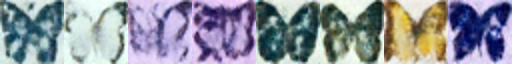

In [8]:
make_grid(images.images)

In [6]:
dataset = load_dataset("../../data/pastai_images/")
img_size = 96
batch_size = 16

Resolving data files:   0%|          | 0/4688 [00:00<?, ?it/s]

Using custom data configuration pastai_images-a2959c3d1f28284c
Found cached dataset imagefolder (/home/alka/.cache/huggingface/datasets/imagefolder/pastai_images-a2959c3d1f28284c/0.0.0/e872d3ec27c6c200a8881a4af52930df7eca3372b19aa4d0f5db74a2fded8141)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
preprocess = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


def _transform(examples):
    images = [preprocess(img.convert("RGB")) for img in examples["image"]]
    return {"images": images}

In [8]:
dataset.set_transform(_transform)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=batch_size, shuffle=True, num_workers=8)

torch.Size([8, 3, 96, 96])


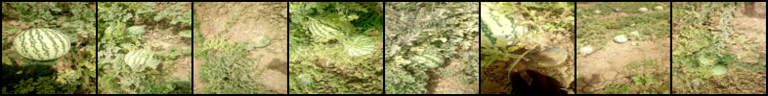

In [10]:
xb = next(iter(train_loader))["images"][:8]
print(xb.shape)
show_images(xb).resize((8*img_size, img_size))

In [11]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1_000, beta_schedule="squaredcos_cap_v2")

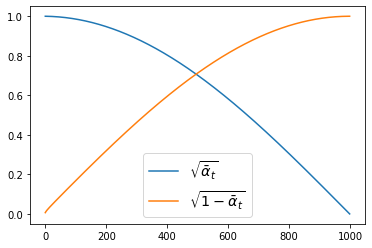

In [12]:
plt.plot(noise_scheduler.alphas_cumprod.cpu()**0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu())**0.5, label=r"${\sqrt{1 - \bar{\alpha}_t}}$")
plt.legend(fontsize="x-large")
plt.show()

In [13]:
timesteps = torch.linspace(0, 999, 8).long()
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999])

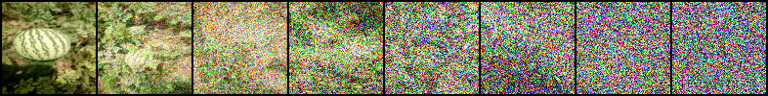

In [14]:
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
show_images(noisy_xb).resize((8*img_size, img_size))

In [15]:
model = UNet2DModel(
    sample_size=img_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)
model.to(device)
model

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Con

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

In [17]:
losses = []
num_epochs = 30

In [18]:
%%time

scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):
    for step, batch in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        
        clean_imgs = batch["images"].to(device)

        noise = torch.randn(clean_imgs.shape).to(clean_imgs.device)
        bs = clean_imgs.shape[0]

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_imgs.device).long()
        noisy_imgs = noise_scheduler.add_noise(clean_imgs, noise, timesteps)
        
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16):
            noise_pred = model(noisy_imgs, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        losses.append(loss.item())
        
        gc.collect()
        torch.cuda.empty_cache()
        
    epoch_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f"Epoch:{epoch+1}, loss: {epoch_loss}")

  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:1, loss: 0.10811012706786088


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:2, loss: 0.07432226224487755


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:3, loss: 0.06912570233447254


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:4, loss: 0.06723063179759035


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:5, loss: 0.06789857579503246


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:6, loss: 0.0695780156110334


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:7, loss: 0.06704761941659776


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:8, loss: 0.06892180477138672


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:9, loss: 0.06385132847131315


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:10, loss: 0.06739573440047254


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:11, loss: 0.06381776546201201


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:12, loss: 0.0627603885612797


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:13, loss: 0.07009375619832363


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:14, loss: 0.06512768979187508


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:15, loss: 0.0654942924156785


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:16, loss: 0.06317081402211669


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:17, loss: 0.06349006430611472


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:18, loss: 0.0654953234024829


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:19, loss: 0.06363921942119408


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:20, loss: 0.060683501286769075


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:21, loss: 0.06331438743493459


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:22, loss: 0.06310246838415645


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:23, loss: 0.06412419498144767


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:24, loss: 0.06246063267691347


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:25, loss: 0.0654342354119536


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:26, loss: 0.06330504010943219


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:27, loss: 0.06354126827823119


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:28, loss: 0.06474038420098836


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:29, loss: 0.06272355578966922


  0%|          | 0/293 [00:00<?, ?it/s]

Epoch:30, loss: 0.06502867907400119
CPU times: user 43min 52s, sys: 12min 55s, total: 56min 48s
Wall time: 1h 21min 44s


In [19]:
pastai_pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [22]:
os.makedirs("models/pastai_baseline", exist_ok=True)
pastai_pipeline.save_pretrained("models/pastai_baseline")

In [23]:
%%time

sample = torch.randn(8, 3, 96, 96).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 52.6 s, sys: 8.97 ms, total: 52.6 s
Wall time: 52.4 s


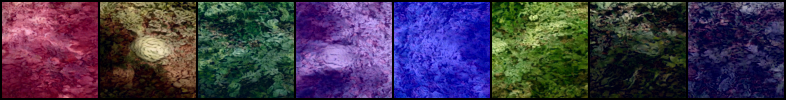

In [25]:
show_images(sample)

In [31]:
%%time

sample0 = torch.randn(8, 3, 96, 96).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample0, t).sample
    sample0 = noise_scheduler.step(residual, t, sample0).prev_sample

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 45s


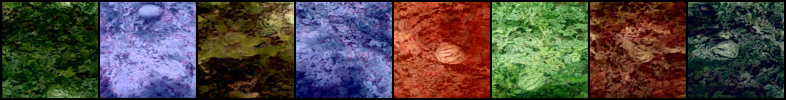

In [32]:
show_images(sample0)

In [33]:
%%time

sample1 = torch.randn(8, 3, 96, 96).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample1, t).sample
    sample1 = noise_scheduler.step(residual, t, sample1).prev_sample

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 47s, sys: 0 ns, total: 1min 47s
Wall time: 1min 47s


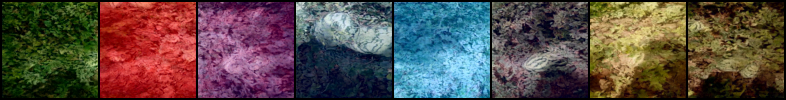

In [34]:
show_images(sample1)

In [35]:
%%time

sample2 = torch.randn(8, 3, 96, 96).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample2, t).sample
    sample2 = noise_scheduler.step(residual, t, sample2).prev_sample

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 48s, sys: 0 ns, total: 1min 48s
Wall time: 1min 48s


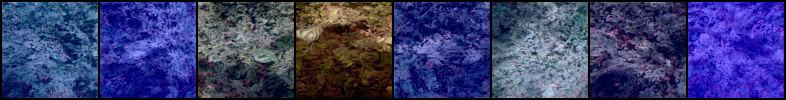

In [36]:
show_images(sample2)

In [37]:
%%time

sample3 = torch.randn(8, 3, 96, 96).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(sample3, t).sample
    sample3 = noise_scheduler.step(residual, t, sample3).prev_sample

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 1min 48s


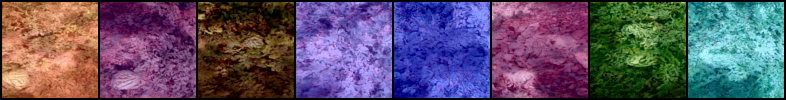

In [38]:
show_images(sample3)